In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "ExplanationPairSentencesTasks":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")

# import the different modules
from src.data_module.hatexplain import CLSTokenHateXPlainDM
from src.data_module.esnli import CLSTokenESNLIDM
from src.data_module.yelp_hat import CLSTokenYelpHat50DM, CLSTokenYelpHatDM
from pur_attention_key_reg import AttitModel
from notebooks.attention_based.utils.ckp_config import *

# external librairies
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm

from modules.metrics.geometry import cosine_sim, effective_rank

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f">> device : {DEVICE}")

>> current directory : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks
>> cache path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache
>> model path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\models
>> dataset path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\dataset
>> logs path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\logs
>> device : cuda


In [21]:
reg_params = [0.005, 0.5, 1, 2, 4, 6]

# HateXplain

In [12]:
%%capture
sim_k_dict = {
    f"lambda={i}" : 0 for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : 0 for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenHateXPlainDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="hatexplain",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_hatexplain_lbd={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_hatexplain_lbd={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="")
            sim_v = cosine_sim(v[0], padding_mask, normalize="")

            # update dictionnaries
            sim_k_dict[f"lambda={i}"] += sim_k.sum().item()
            sim_v_dict[f"lambda={i}"]+= sim_v.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = sim_k_dict[k] / dm.n_data
    sim_v_dict[k] = sim_v_dict[k] / dm.n_data
;

In [13]:
sim_k_dict

{'lambda=0.005': 0.6460663630320383,
 'lambda=0.5': 0.6653637298950562,
 'lambda=1': 0.6897095913166279,
 'lambda=2': 0.5935062424198643,
 'lambda=4': 0.6057427958086565,
 'lambda=6': 0.5679228005108533}

In [14]:
sim_v_dict

{'lambda=0.005': 0.5339903509294665,
 'lambda=0.5': 0.637585480053265,
 'lambda=1': 0.5988712988577567,
 'lambda=2': 0.6217991549212176,
 'lambda=4': 0.5852670877187459,
 'lambda=6': 0.6240997333545704}

''

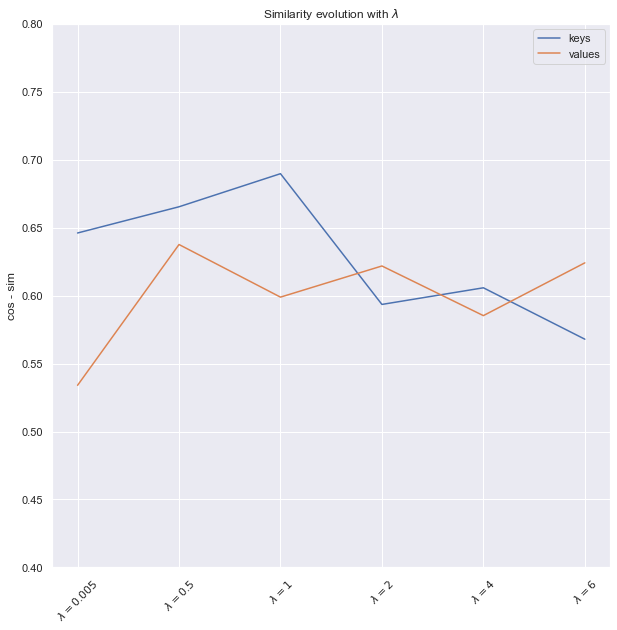

In [15]:
# the corresponding graphic
figure = plt.figure(figsize=(10, 10))
plt.plot(list(range(len(sim_k_dict))), list(sim_k_dict.values()), label="keys")
plt.plot(list(range(len(sim_v_dict))), list(sim_v_dict.values()), label="values")
plt.ylim(.4, .8)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
;

# Yelp Hat

In [22]:
%%capture
sim_k_dict = {
    f"lambda={i}" : 0 for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : 0 for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=300
                 )

dm = CLSTokenYelpHat50DM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="yelphat50",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_yelphat50_lbd={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_yelphat50_lbd={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="")
            sim_v = cosine_sim(v[0], padding_mask, normalize="")

            # update dictionnaries
            sim_k_dict[f"lambda={i}"] += sim_k.sum().item()
            sim_v_dict[f"lambda={i}"]+= sim_v.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = sim_k_dict[k] / dm.n_data
    sim_v_dict[k] = sim_v_dict[k] / dm.n_data
;

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/loicf/Documents/IRISA/ExplanationPairSentencesTasks/.cache/logs/PurAttentionReg/entropy_reg_yelphat50_lbd=1/checkpoints/best.ckpt'

In [18]:
sim_k_dict

{'lambda=0.005': 207.09082078933716,
 'lambda=0.5': 187.20919704437256,
 'lambda=1': 0,
 'lambda=2': 0,
 'lambda=4': 0,
 'lambda=6': 0}

In [19]:
sim_v_dict

{'lambda=0.005': 122.79116725921631,
 'lambda=0.5': 177.5964059829712,
 'lambda=1': 0,
 'lambda=2': 0,
 'lambda=4': 0,
 'lambda=6': 0}

''

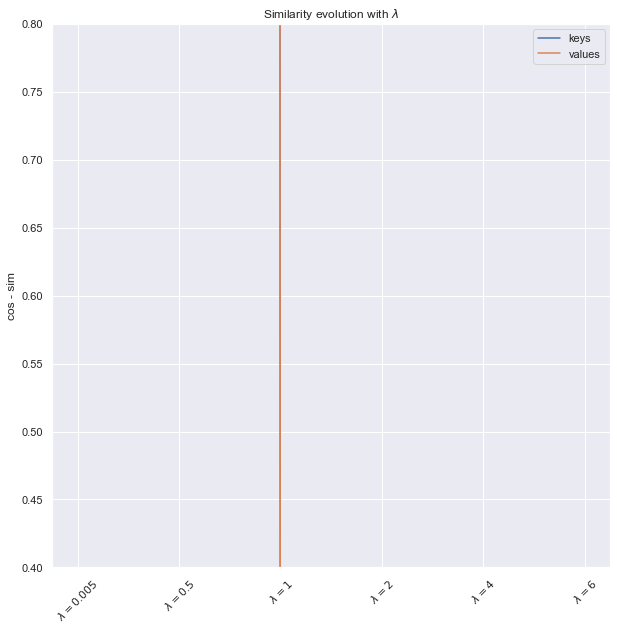

In [20]:
# the corresponding graphic
figure = plt.figure(figsize=(10, 10))
plt.plot(list(range(len(sim_k_dict))), list(sim_k_dict.values()), label="keys")
plt.plot(list(range(len(sim_v_dict))), list(sim_v_dict.values()), label="values")
plt.ylim(.4, .8)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
;

# E-SNLI

In [13]:
%%capture
sim_k_dict = {
    f"n_layer={i+1}" : np.zeros((i+1,)) for i in range(5)
}
sim_v_dict = {
    f"n_layer={i+1}" : np.zeros((i+1,)) for i in range(5)
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenESNLIDM(**dm_kwargs)
dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader()



model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="esnli",
        num_class=dm.num_class,
        opt="adam"
)
cpt = torch.tensor([0, 0, 0, 0, 0], device=DEVICE)
for l in range(2) :

    # update the args for the model
    model_args["num_layers"] = l+1
    ckp = os.path.join(log_path, "PurAttention", f"run=0_esnli_l=0{l+1}_h=1_adam", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttention", f"run=0_esnli_l=0{l+1}_h=1_adam", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            output = model(ids=ids, mask=padding_mask)

            # check accuracy
            cl = output["logits"].argmax(dim=-1)
            cpt[l] += (cl == batch["y_true"].to(DEVICE)).sum().item()

            # get the embeddings
            k, v = output["key_embeddings"], output["value_embeddings"]

            for i in range(l+1):
                # calculus of the metrics
                sim_k = cosine_sim(k[i], padding_mask, normalize="")
                sim_v = cosine_sim(v[i], padding_mask, normalize="")

                sim_k_dict[f"n_layer={l+1}"][i] += sim_k.sum().item()
                sim_v_dict[f"n_layer={l+1}"][i] += sim_v.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

nb_samples = len(test_dataloader.dataset)

for k in sim_k_dict:
    sim_k_dict[k] = sim_k_dict[k] / nb_samples
    sim_v_dict[k] = sim_v_dict[k] / nb_samples

In [14]:
(cpt.cpu() / 999)

tensor([0.6276, 0.7297, 0.0000, 0.0000, 0.0000])

In [15]:
sim_k_dict

{'n_layer=1': array([0.65682015]),
 'n_layer=2': array([0.71875791, 0.48821352]),
 'n_layer=3': array([0., 0., 0.]),
 'n_layer=4': array([0., 0., 0., 0.]),
 'n_layer=5': array([0., 0., 0., 0., 0.])}

In [16]:
sim_v_dict

{'n_layer=1': array([0.52405099]),
 'n_layer=2': array([0.18200549, 0.74587911]),
 'n_layer=3': array([0., 0., 0.]),
 'n_layer=4': array([0., 0., 0., 0.]),
 'n_layer=5': array([0., 0., 0., 0., 0.])}

# Conclusion